In [1]:
import experts

from experts import problems
from experts.problems import ScalarExpertsProblem

import numpy as np
import pandas as pd
import seaborn as sns

# Random outcomes

Consider a random sequence of zeros and ones. This is the outcome that we are trying to predict. It's really a time-series and we will attempt to train a learning algorithm that will make better predictions towards the end of this sequence, compared to earlier predictions.

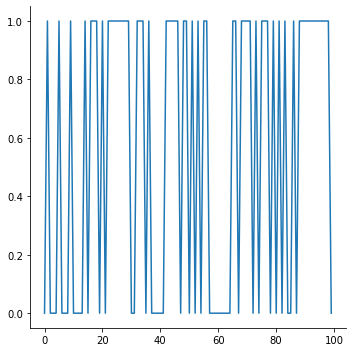

In [2]:
np.random.seed(42)

T = 100

y = np.random.randint(0, 2, T)

sns.relplot(x = range(100), y = y, kind = "line")

Outcomes are 0/1 but predictions will be in the range [0, 1]
and represent the probability that the outcome at time t
is 1.

Both out learning algorithm and a pool of experts will
make predictions for all time t. So the learner predictions
will result in a sequence of values in [0, 1] the same
length as the outcome as will the predictions of each
expert.

Therefore to create n = 10 experts,
each making predictions for a vector of length 100,
we simply create a matrix with 100 rows and n = 10 columns.
One column per expert, one row per time step.

In [3]:
n = 10

E1 = np.random.rand(n, T)

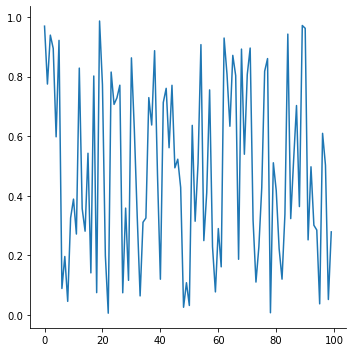

In [4]:
sns.relplot(x = range(100), y = E1[0, :], kind = "line")

To run the mixture of experts algorithm we first
initialise a ScalarExpertsProblem
with the experts' prediction matrix
and outcome vector.

In [5]:
A = ScalarExpertsProblem(E1, y)

Now we can call the mixture method,
passing a choice of learning rate,
if we choose.

In [6]:
beta = 0.01

A.mixture(beta)

## Expert losses

The result object is a dictionary containing the predictions of the learner and the experts
as well as the learner loss at each time step and the loss of every expert at every time
step.

For example, if we want to calculate the total loss incurred by each
of the pool of ten experts then we simply extract the `result["expert-loss"]`
matrix and sum the columns.

In [7]:
expert_losses = np.sum(A.expertsLossMatrix, axis = 1)
print(expert_losses)

[49.43446525 49.07555715 47.09453138 42.99825425 53.77978776 47.22808981
 50.81558079 51.12893154 53.15996992 49.02902251]


The best expert is the expert with the lowest error. In this case, that is expert:

In [8]:
best_expert_index = np.argmin(expert_losses)
print(best_expert_index)

3


And the loss made by that best expert is loss corresponding to that index or, equivalently, the minimum value of the expert_losses vector.

In [9]:
best_expert_total_loss = np.min(expert_losses)
print(best_expert_total_loss)

42.998254252080486


Compare that to the learner's total loss, which is only slightly more.

In [10]:
learner_total_loss = np.sum(A.learnerLossVector, axis = 0)
print(learner_total_loss)

49.043308128118596


In fact, the learner only accumulated less than 3% more loss over the one hundred time steps.

In [11]:
abs(best_expert_total_loss - learner_total_loss)/best_expert_total_loss

0.14058835599693256

## Plots

First, lettuce plot the loss of the best expert and the learner against time.

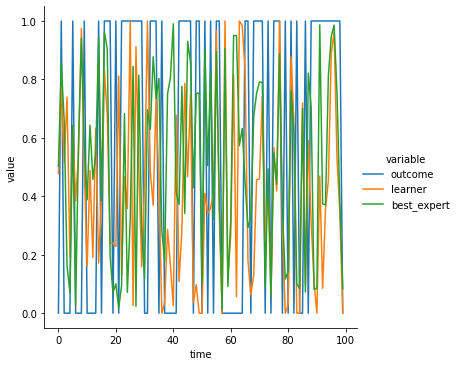

In [12]:
df = pd.DataFrame(
    dict(
        time = np.arange(100),
        outcome = y,
        learner = A.predictionVector,
        best_expert = A.expertsPredictionMatrix[best_expert_index, :]
        )
    )

df_long = pd.melt(df, ['time'])

sns.relplot(x = "time", y = "value", hue = "variable", kind = "line", data = df_long)

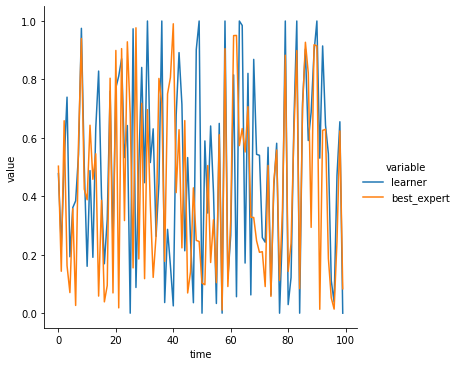

In [13]:
df = pd.DataFrame(
    dict(
        time = np.arange(100),
        learner = A.learnerLossVector,
        best_expert = A.expertsLossMatrix[best_expert_index, :]
        )
    )

df_long = pd.melt(df, ['time'])

sns.relplot(x = "time", y = "value", hue = "variable", kind = "line", data = df_long)

It seems clear that the learner has learned to follow the predictions of the best expert. In fact, the learner starts tracking the best expert at an early stage.

Now lettuce look at the cumulative loss over time. We would expect to see that the total loss of the learner tracks the loss of the best expert eventually. Early on we might see that the learner does much worse.

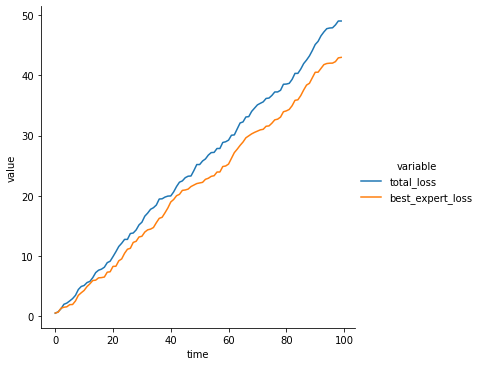

In [14]:
df_cum = pd.DataFrame(
    dict(
        time = np.arange(100),
        total_loss = A.learnerLossVector.cumsum(),
        best_expert_loss = A.expertsLossMatrix[best_expert_index, :].cumsum()
        )
    )

df_cum_long = pd.melt(df_cum, ['time'])

sns.relplot(x = "time", y = "value", hue = "variable", kind = "line", data = df_cum_long)

In this experiment we saw that the learner tracks the best expert and accumulates only slightly more loss over the timespan of the experiment. However, the best expert here isn't really successful at making predictions either so even if the learner was simply making random predictions we would probably see the same behaviour. So what happens when there is an expert among our ten experts that makes good predictions? In the next section we contrive an experiment to test this.

# Outcomes as experts

An easy way to create an expert that makes good predictions is simply to copy the outcome sequence and add that to the pool of experts.

In [15]:
E2 = E1.copy()
E2[n - 1, :] = y

Of course, this best expert won't incur any loss because it's predictions are identical to the outcome sequence for the full timespan. So we can add a bit of noise to make it seem like this is an expert that has a pretty good idea about the outcome sequence but doesn't get it exactly right. (Shouldn't I add noise if the value is zero and subtract it when the outcome is 1?)

In [16]:
import random

for t in range(T):
  a = random.gauss(0, 0.1)
  if 0 <= a + E2[n - 1, t] <= 1:
    E2[n - 1, t] = a + E2[n - 1, t]

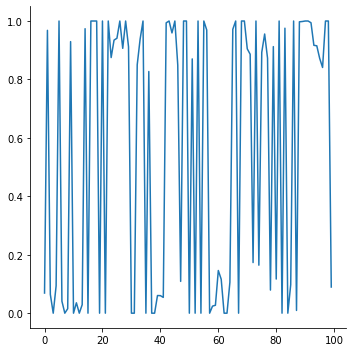

In [17]:
sns.relplot(x = range(100), y = E2[n - 1, :], kind = "line")

Run the mixture algorithm with the same outcomes but with this new pool of experts that includes the noisy copy of the outcome.

In [18]:
A = ScalarExpertsProblem(E2, y)
A.mixture(beta)

Recalculate the index of the best expert.

In [19]:
expert_losses = np.sum(A.expertsLossMatrix, axis = 1)
best_expert_total_loss = np.min(expert_losses)
best_expert_index = np.argmin(expert_losses)

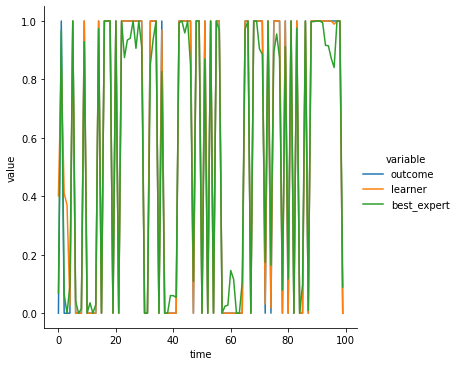

In [20]:
df = pd.DataFrame(
    dict(
        time = np.arange(100),
        outcome = y,
        learner = A.predictionVector,
        best_expert = A.expertsPredictionMatrix[best_expert_index, :]
        )
    )

df_long = pd.melt(df, ['time'])

sns.relplot(x = "time", y = "value", hue = "variable", kind = "line", data = df_long)

Plot the learner loss and best expert loss against time.

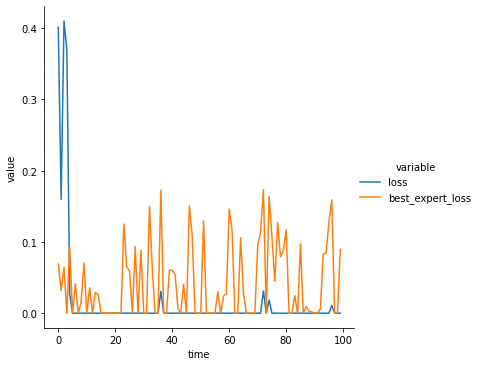

In [21]:
df = pd.DataFrame(
    dict(
        time = np.arange(100),
        loss = A.learnerLossVector,
        best_expert_loss = A.expertsLossMatrix[best_expert_index, :]
    )
)

df_long = pd.melt(df, ['time'])

sns.relplot(x = "time", y = "value", hue = "variable", kind = "line", data = df_long)

Here you can see that the best expert only incurs loss due to noise and the learner quickly picks up on the skill of this particular forecaster and makes apparently better predictions (because only 0/1 output?). Notice that early on the learner was beginning to make some much greater losses before it had honed in on the best expert.

Finally, lettuce plot the cumulative loss of both the best expert and the learner.

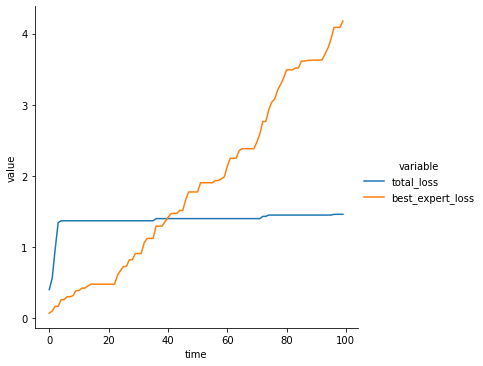

In [22]:
df_cum = pd.DataFrame(
    dict(
        time = np.arange(100),
        total_loss = A.learnerLossVector.cumsum(),
        best_expert_loss = A.expertsLossMatrix[best_expert_index, :].cumsum()
        )
    )

df_cum_long = pd.melt(df_cum, ['time'])

sns.relplot(x = "time", y = "value", hue = "variable", kind = "line", data = df_cum_long)

Here we can see that the learner quickly accumulates significantly greater losses than the best expert but once it starts tracking the best expert it makes no further loss.